In [1]:
import os
os.chdir("../../")

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import scanpy as sc
import matplotlib
import scnet as sn
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [5]:
sc.settings.set_figure_params(dpi=100)
sc.settings.figdir = "./results/integration/tabula_senis_muris/new/"

In [6]:
condition_key = "method_age"
cell_type_key = 'cell_ontology_class'
target_conditions = ["droplet - 3m", "facs - 3m"]

In [7]:
base_path = "/media/pgdrive/sharif/exosomians/mohsen/data/"

# Loading mouse brain datasets and data preparation

In [8]:
# adata = sc.read(os.path.join(base_path, "./tabula_senis/tabula_senis_normalized_all_hvg.h5ad"))
# adata

In [55]:
adata = sc.read("./data/tabula_senis_normalized_all_hvg.h5ad")

In [56]:
adata

AnnData object with n_obs × n_vars = 356213 × 5000 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'method_tissue', 'method_age', 'Tech'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [10]:
source_adata = adata[~adata.obs['tissue'].isin(['Trachea'])]
source_adata = source_adata[~source_adata.obs[condition_key].isin(target_conditions)]
source_adata

View of AnnData object with n_obs × n_vars = 264287 × 5000 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'method_tissue', 'method_age', 'Tech'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [11]:
target_adata = adata[adata.obs[condition_key].isin(target_conditions)]
target_adata

View of AnnData object with n_obs × n_vars = 90120 × 5000 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'method_tissue', 'method_age', 'Tech'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [12]:
source_adata.obs['Tech'] = 'Tabula Senis'
target_adata.obs['Tech'] = 'Tabula Muris'

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


## Train/Test Split

In [13]:
train_adata, valid_adata = sn.utils.train_test_split(source_adata, 0.80)

In [14]:
train_adata.shape, valid_adata.shape

((211429, 5000), (52858, 5000))

In [15]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())
n_conditions

8

# Create & Train model with training data

In [16]:
network = sn.archs.scNet(x_dimension=train_adata.shape[1], 
                         z_dimension=40,
                         architecture=[128, 32],
                         n_conditions=n_conditions,
                         use_batchnorm=False,
                         lr=0.001,
                         alpha=0.0001,
                         beta=25,
                         eta=1000,
                         clip_value=10.0,
                         loss_fn='mse',
                         mmd_computation_method='5',
                         model_path="./models/CVAE/tabula_senis_muris/before/",
                         dropout_rate=0.1,
                         output_activation='relu')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## We assign each study to a numerical label 

In [17]:
train_adata.obs[condition_key].value_counts()

droplet - 30m    44610
droplet - 18m    35689
droplet - 24m    30154
droplet - 21m    28584
facs - 18m       26571
facs - 24m       24486
droplet - 1m     20753
facs - 21m         582
Name: method_age, dtype: int64

In [18]:
conditions = adata.obs[condition_key].unique().tolist()
condition_encoder = sn.utils.create_dictionary(sorted(conditions), target_conditions)
condition_encoder

{'droplet - 18m': 0,
 'droplet - 1m': 1,
 'droplet - 21m': 2,
 'droplet - 24m': 3,
 'droplet - 30m': 4,
 'facs - 18m': 5,
 'facs - 21m': 6,
 'facs - 24m': 7}

## Training the network

In [ ]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=1000,
              n_per_epoch=0,
              batch_size=512, 
              early_stop_limit=30,
              lr_reducer=20, 
              save=True, 
              retrain=False,
              verbose=5)

In [ ]:
network.condition_encoder

In [21]:
# encoder_labels, _ = sn.utils.label_encoder(
#     source_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [22]:
# latent_adata = network.to_mmd_layer(source_adata, encoder_labels, encoder_labels)
# latent_adata

AnnData object with n_obs × n_vars = 264287 × 32 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'method_tissue', 'method_age', 'Tech'

In [23]:
# sc.pp.neighbors(latent_adata)
# sc.tl.umap(latent_adata)

... storing 'Tech' as categorical


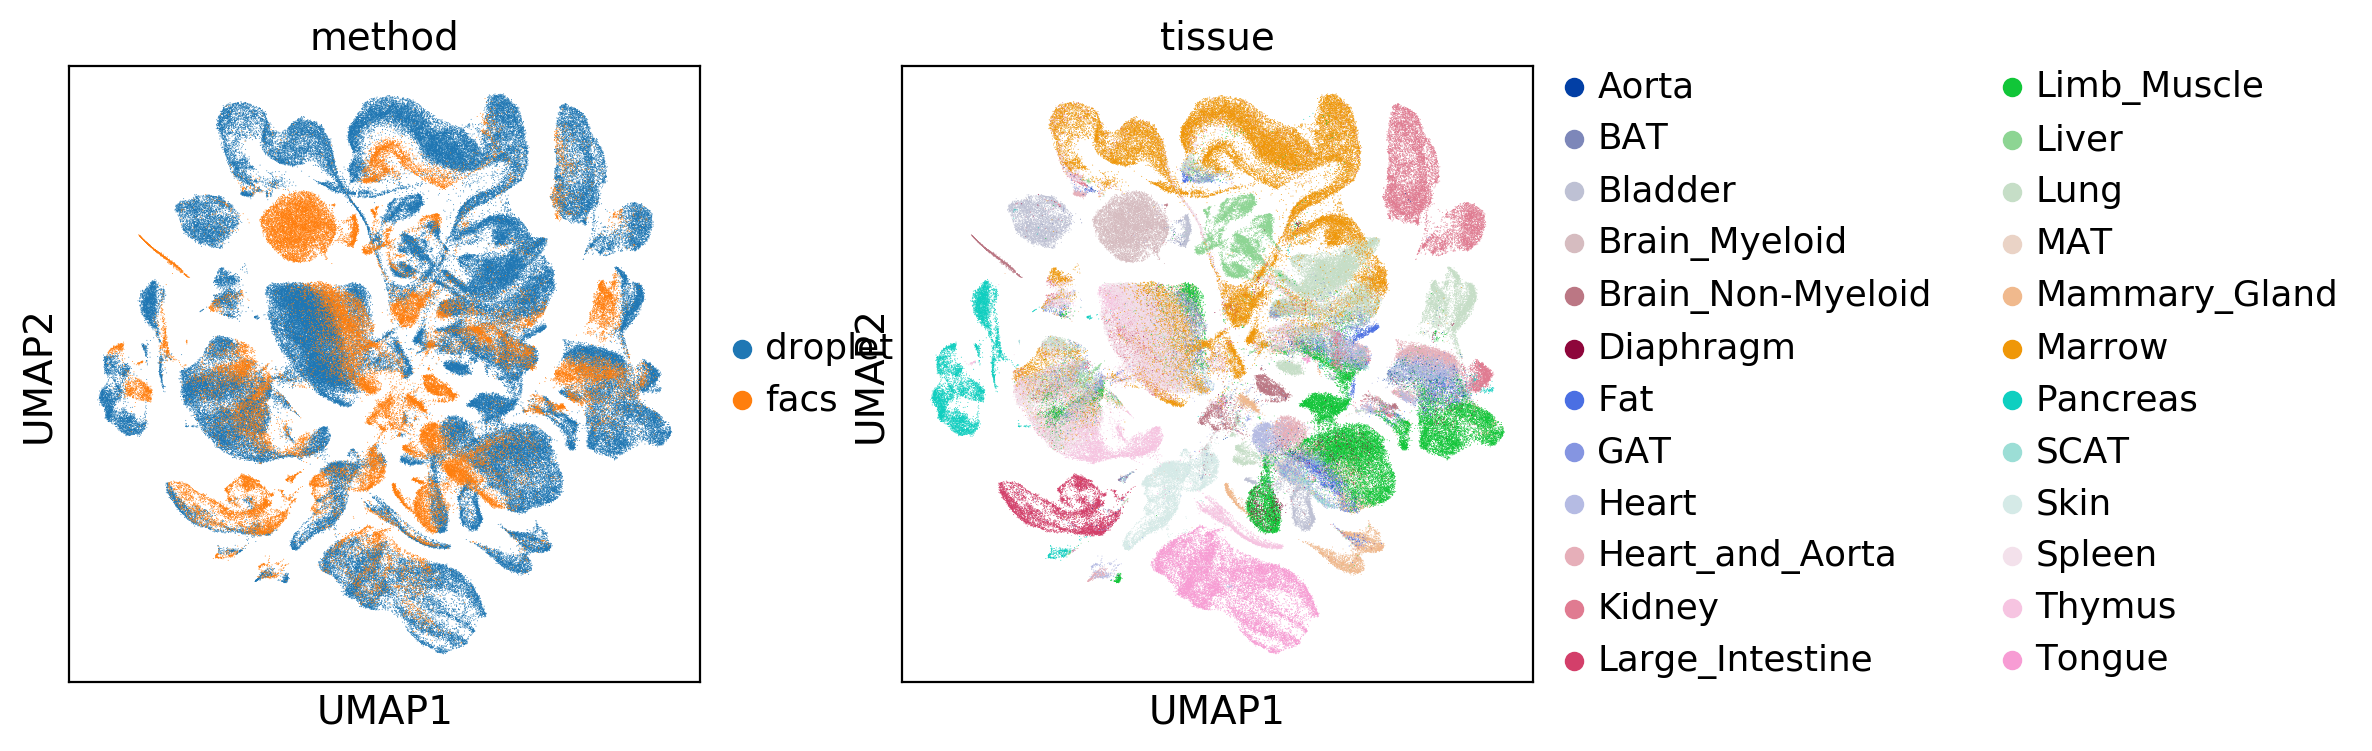

In [24]:
# sc.pl.umap(latent_adata, color=['method', 'tissue'], wspace=0.2)

In [25]:
# sc.pl.umap(latent_adata, color='method', frameon=False, save='_pretrain_method.pdf')
# sc.pl.umap(latent_adata, color='tissue', frameon=False, save='_pretrain_tissue.pdf', palette=sc.pl.palettes.godsnot_102)
# sc.pl.umap(latent_adata, color='age', frameon=False, save='_pretrain_age.pdf', palette=sc.pl.palettes.zeileis_28)
# sc.pl.umap(latent_adata, color=condition_key, frameon=False, save=f'_pretrain_{condition_key}.pdf', palette=sc.pl.palettes.godsnot_102)

# Perfroming architecture Surgery

In [ ]:
new_network = sn.operate(network, 
                          new_conditions=target_conditions,
                          init='Xavier', 
                          freeze=True,
                          freeze_expression_input=True,
                          remove_dropout=False,
                          new_training_kwargs={"beta": 30},
                          new_network_kwargs={"mmd_computation_method": "general"}
                         )

In [ ]:
new_network.condition_encoder

## Train with small new dataset containing out-of-sample condition

In [ ]:
train_adata, valid_adata = sn.utils.train_test_split(target_adata, 0.80)

In [ ]:
train_adata.shape, valid_adata.shape

In [ ]:
new_network.model_path = "./models/CVAE/tabula_senis_muris/after/"

In [ ]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=1000,
                  batch_size=512, 
                  early_stop_limit=50,
                  lr_reducer=40, 
                  n_per_epoch=0,
                  save=True,
                  retrain=False,
                  verbose=5)

# Muris Latent Visualization

In [ ]:
# encoder_labels, _ = sn.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [ ]:
# latent_adata = new_network.to_mmd_layer(adata_out_of_sample, encoder_labels, encoder_labels)
# latent_adata

In [ ]:
# sc.pp.neighbors(latent_adata)
# sc.tl.umap(latent_adata)

In [ ]:
# sc.pl.umap(latent_adata, color='method', frameon=False, save='_after_surgery_muris_method.pdf')
# sc.pl.umap(latent_adata, color='tissue', frameon=False, save='_after_surgery_muris_tissue.pdf', palette=sc.pl.palettes.godsnot_102)
# sc.pl.umap(latent_adata, color='age', frameon=False, save='_after_surgery_muris_age.pdf', palette=sc.pl.palettes.zeileis_28)
# sc.pl.umap(latent_adata, color=condition_key, frameon=False, save=f'_after_surgery_muris_{condition_key}.pdf', palette=sc.pl.palettes.godsnot_102)

# Muris + Senis Latent Visualization

In [34]:
target_adata = sn.utils.remove_sparsity(target_adata)

In [35]:
adata = source_adata.concatenate(target_adata)

In [36]:
encoder_labels, _ = sn.utils.label_encoder(adata, 
                                           label_encoder=new_network.condition_encoder, 
                                           condition_key=condition_key)

In [37]:
latent_adata = new_network.to_mmd_layer(adata, encoder_labels, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 354407 × 32 
    obs: 'FACS.selection', 'Tech', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'

In [38]:
latent_adata.obs['tissue'].value_counts()

Marrow               54737
Spleen               39552
Limb_Muscle          32722
Lung                 29758
Tongue               24415
Kidney               23480
Mammary_Gland        15577
Brain_Myeloid        13417
Thymus               13322
Bladder              11377
Large_Intestine      10198
Liver                10153
Heart                 9669
Pancreas              9585
Trachea               9330
Skin                  9314
Heart_and_Aorta       8613
Brain_Non-Myeloid     7249
Fat                   6777
SCAT                  3755
GAT                   3406
MAT                   3014
BAT                   2223
Diaphragm             1858
Aorta                  906
Name: tissue, dtype: int64

In [39]:
latent_adata.obs.loc[latent_adata.obs['tissue'] == 'Heart_and_Aorta', 'tissue'] = 'Heart'

In [42]:
# latent_adata.obs['tissue'].cat.remove_categories(removals=['Heart_and_Aorta'], inplace=True)

In [43]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

In [51]:
sc.pp.subsample(latent_adata, fraction=1.0, random_state=100) # shuffle latent adata for visualization purpose

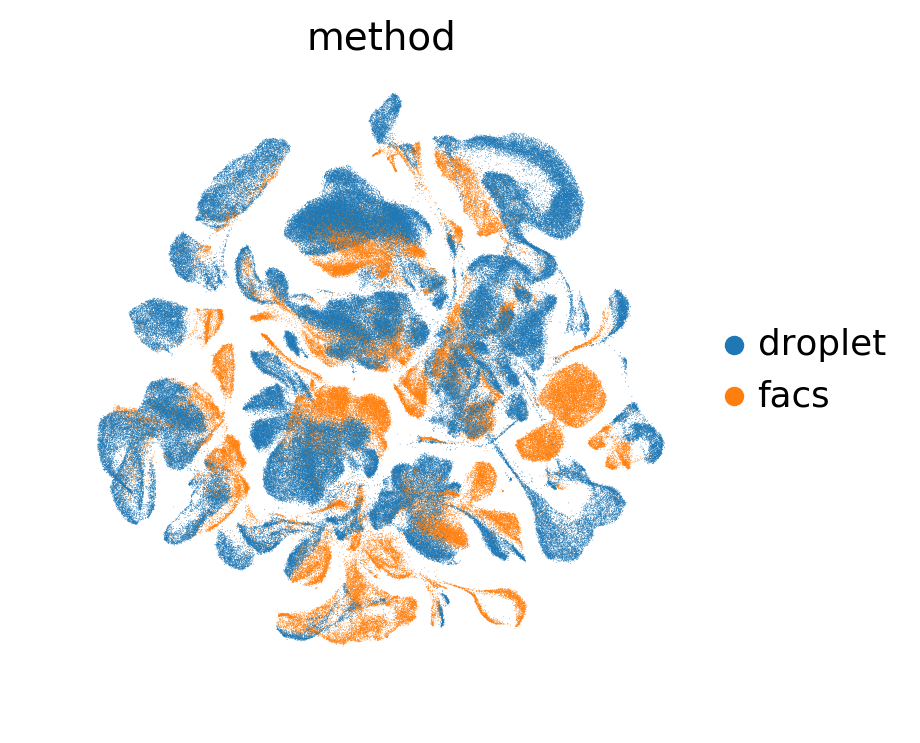

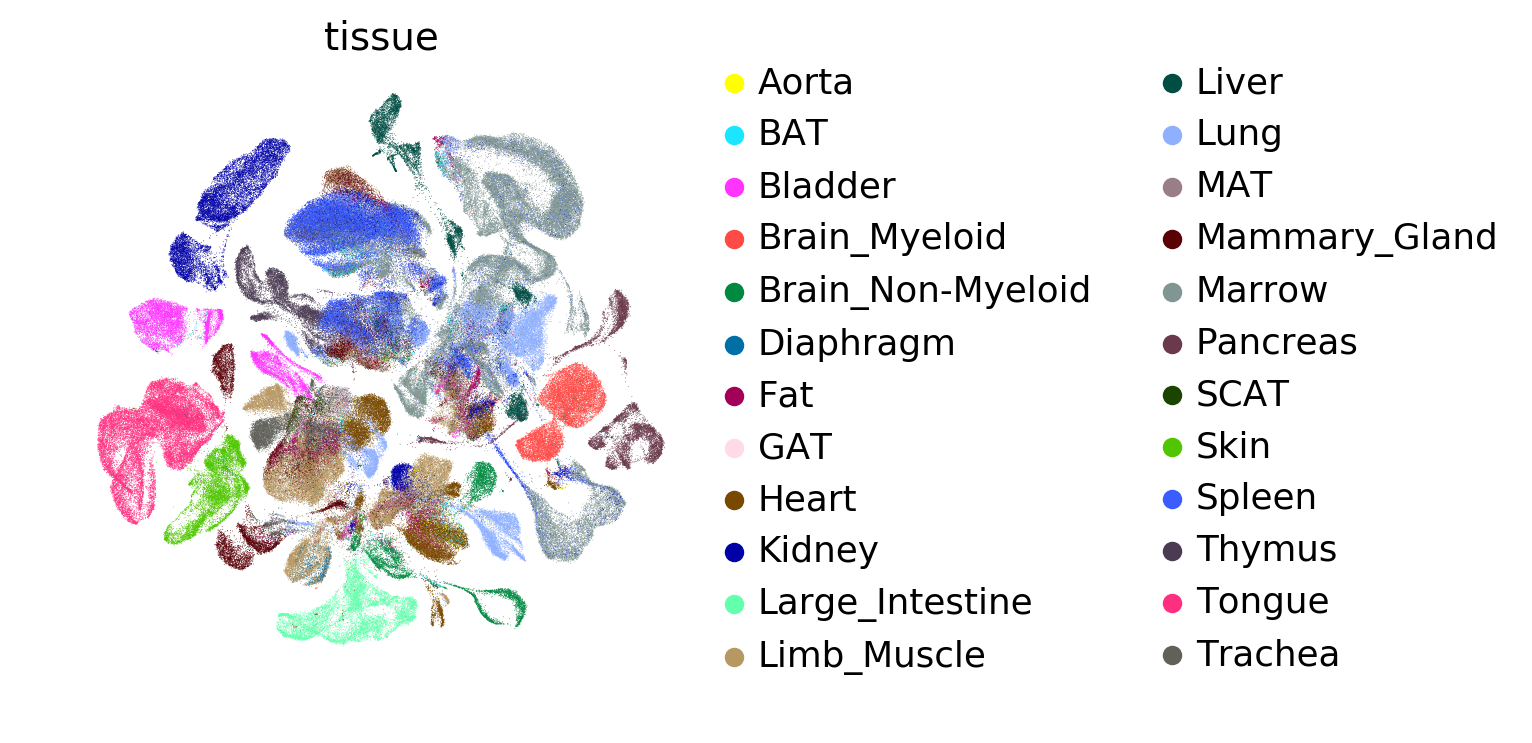

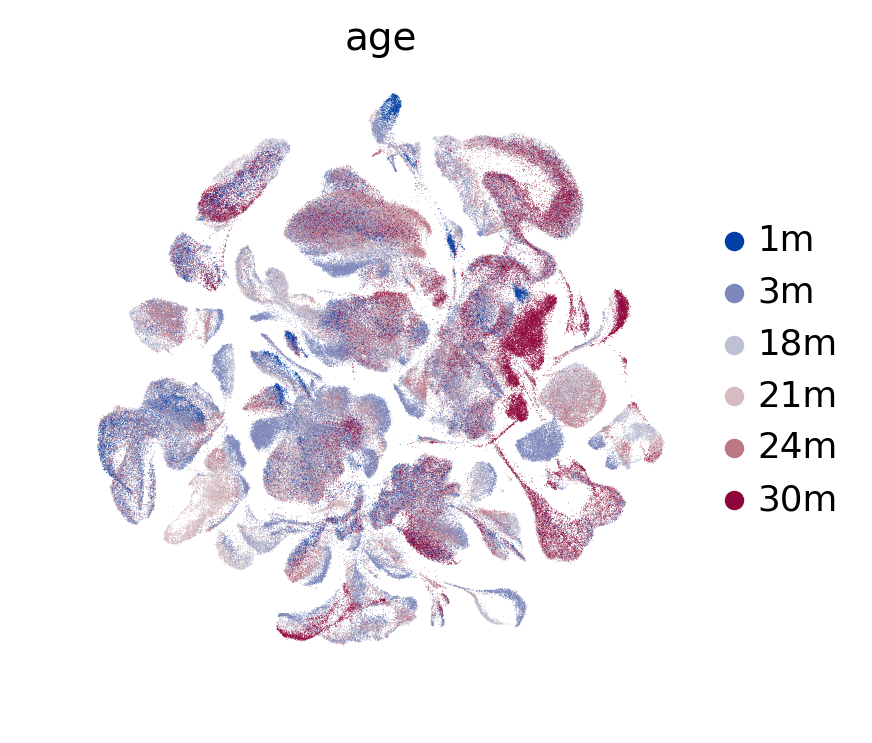

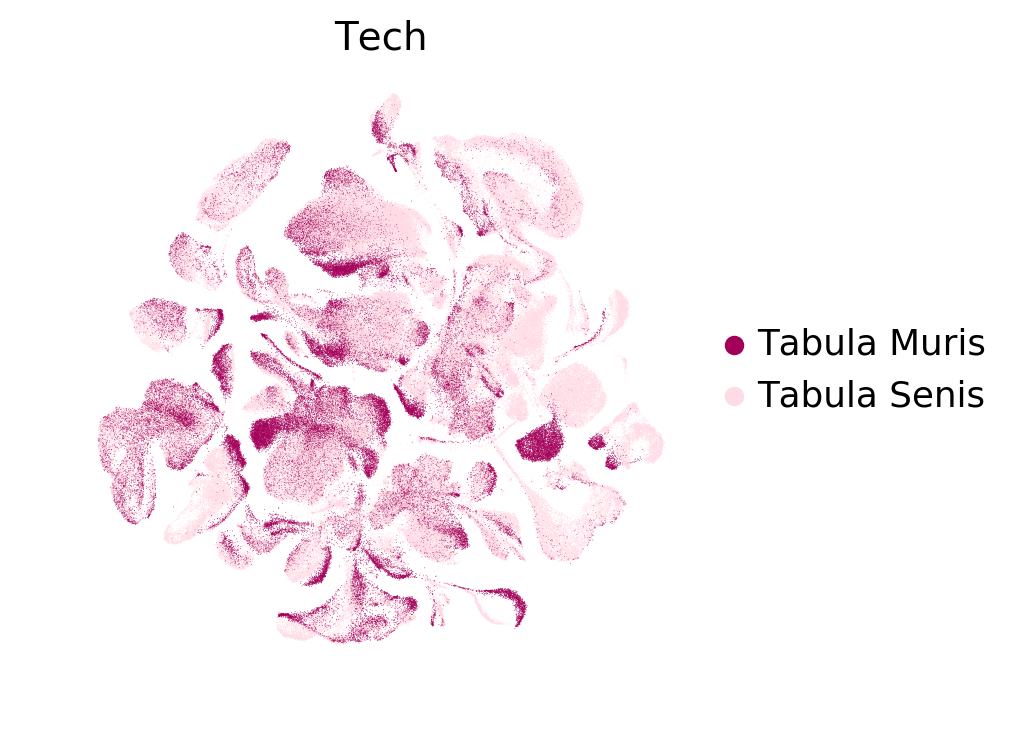

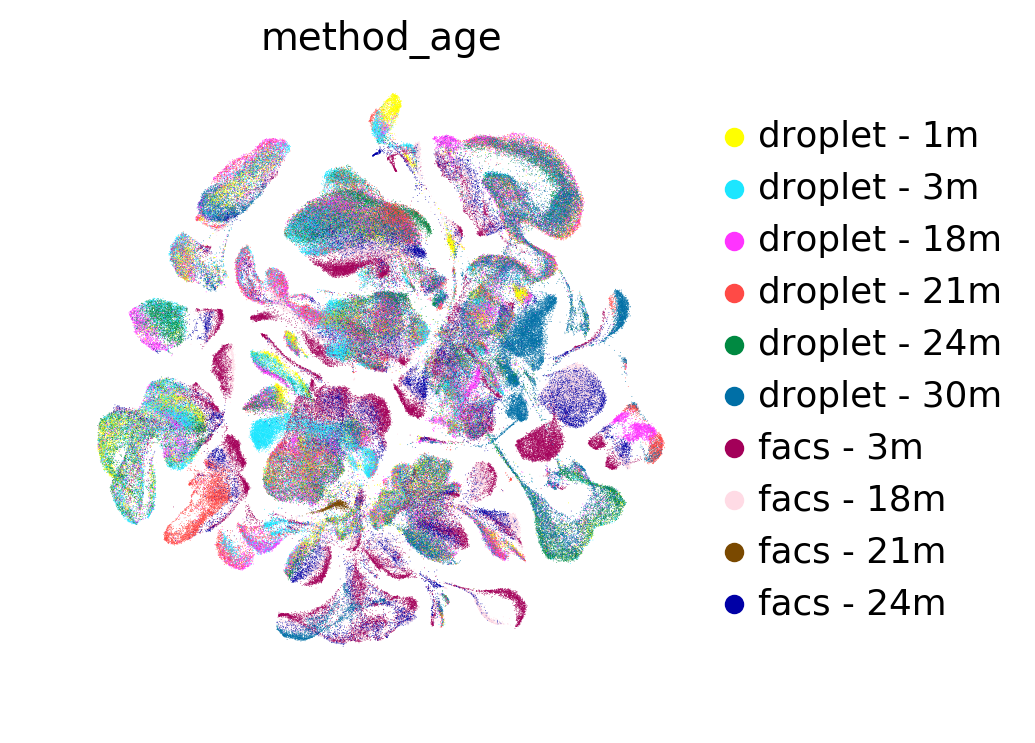

In [52]:
sc.pl.umap(latent_adata, color='method', frameon=False, save='_after_surgery_senis+muris_method.pdf')
sc.pl.umap(latent_adata, color='tissue', frameon=False, save='_after_surgery_senis+muris_tissue.pdf', palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(latent_adata, color='age', frameon=False, save='_after_surgery_senis+muris_age.pdf', palette=sc.pl.palettes.zeileis_28)
sc.pl.umap(latent_adata, color='Tech', frameon=False, save='_after_surgery_senis+muris_Tech.pdf', palette=sc.pl.palettes.godsnot_102[6:])
sc.pl.umap(latent_adata, color=condition_key, frameon=False, save=f'_after_surgery_senis+muris_{condition_key}.pdf', palette=sc.pl.palettes.godsnot_102)

In [47]:
latent_adata.write_h5ad(os.path.join(base_path, 'tabula_senis_muris/latents/all.h5ad'))

In [49]:
latent_adata = sc.read(os.path.join(base_path, 'tabula_senis_muris/latents/all.h5ad'))

In [50]:
latent_adata

AnnData object with n_obs × n_vars = 354407 × 32 
    obs: 'FACS.selection', 'Tech', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    uns: 'Tech_colors', 'age_colors', 'method_age_colors', 'method_colors', 'neighbors', 'tissue_colors', 'umap'
    obsm: 'X_umap'

# Weighted KNN

### 1. Compute Latents for Tabula Senis and Muris

In [18]:
train_latent = latent_adata[latent_adata.obs['Tech'] == 'Tabula Senis']
train_latent

View of AnnData object with n_obs × n_vars = 264287 × 32 
    obs: 'FACS.selection', 'Tech', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    uns: 'Tech_colors', 'age_colors', 'method_age_colors', 'method_colors', 'neighbors', 'tissue_colors', 'umap'
    obsm: 'X_umap'

In [19]:
valid_latent = latent_adata[latent_adata.obs['Tech'] == 'Tabula Muris']
valid_latent

View of AnnData object with n_obs × n_vars = 90120 × 32 
    obs: 'FACS.selection', 'Tech', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    uns: 'Tech_colors', 'age_colors', 'method_age_colors', 'method_colors', 'neighbors', 'tissue_colors', 'umap'
    obsm: 'X_umap'

In [53]:
valid_latent.obs['Tech'].value_count

10X_P4_0_AAACCTGAGATTACCC-1-0-1    Tabula Muris
10X_P4_0_AAACCTGAGTGCCAGA-1-0-1    Tabula Muris
10X_P4_0_AAACCTGCAAATCCGT-1-0-1    Tabula Muris
10X_P4_0_AAACCTGGTAATCGTC-1-0-1    Tabula Muris
10X_P4_0_AAACCTGGTCCAACTA-1-0-1    Tabula Muris
                                       ...     
P9.MAA001887.3_39_F.1.1-1-1-1-1    Tabula Muris
P9.MAA001888.3_39_F.1.1-1-1-1-1    Tabula Muris
P9.MAA001889.3_38_F.1.1-1-1-1-1    Tabula Muris
P9.MAA001892.3_38_F.1.1-1-1-1-1    Tabula Muris
P9.MAA001894.3_39_F.1.1-1-1-1-1    Tabula Muris
Name: Tech, Length: 90120, dtype: category
Categories (1, object): [Tabula Muris]

In [20]:
tissues = valid_latent.obs['tissue'].unique().tolist()

# KNN Training

In [13]:
n_neighbor = 400
threshold = 0.5

# Cell type prediction

In [ ]:
pred_labels, uncertainties = sn.utils.weighted_knn(train_latent, 
                                                   valid_latent, 
                                                   cell_type_key, 
                                                   n_neighbors=20, 
                                                   threshold=0.5, 
                                                   pred_unknown=True, 
                                                   return_uncertainty=True,
                                                   )

In [31]:
true_labels = np.array(valid_latent.obs[cell_type_key].values).reshape(-1, 1)

labels_eval = pred_labels == true_labels
labels_eval = labels_eval.astype(object)

n_correct = len(labels_eval[labels_eval == True])
n_incorrect = len(labels_eval[labels_eval == False]) - len(labels_eval[pred_labels == 'Unknown'])
n_unknown = len(labels_eval[pred_labels == 'Unknown'])

labels_eval[labels_eval == True] = f'Correct ({n_correct})'
labels_eval[labels_eval == False] = f'InCorrect ({n_incorrect})'
labels_eval[pred_labels == 'Unknown'] = f'Unknown ({n_unknown})'

labels_eval_key = f'celltype_evaluation_w_unknown_20_0.5'
uncertainty_key = f'celltype_uncertainty_w_unknown_20_0.5'
pred_labels_key = f'predicted_celltype_w_unknown_20_0.5'

valid_latent.obs[labels_eval_key] = pd.Categorical(labels_eval.reshape(-1, ))
valid_latent.obs[uncertainty_key] = uncertainties
valid_latent.obs[pred_labels_key] = pd.Categorical(pred_labels.reshape(-1, ))

In [ ]:
pred_labels, uncertainties = sn.utils.weighted_knn(train_latent, 
                                                   valid_latent, 
                                                   'tissue', 
                                                   n_neighbors=n_neighbor, 
                                                   threshold=threshold, 
                                                   pred_unknown=True, 
                                                   return_uncertainty=True,
                                                   )

Weighted KNN with n_neighbors = 400 and threshold = 0.5 ... 

In [ ]:
true_labels = np.array(valid_latent.obs['tissue'].values).reshape(-1, 1)

labels_eval = pred_labels == true_labels
labels_eval = labels_eval.astype(object)

n_correct = len(labels_eval[labels_eval == True])
n_incorrect = len(labels_eval[labels_eval == False]) - len(labels_eval[pred_labels == 'Unknown'])
n_unknown = len(labels_eval[pred_labels == 'Unknown'])

labels_eval[labels_eval == True] = f'Correct'
labels_eval[labels_eval == False] = f'InCorrect'
labels_eval[pred_labels == 'Unknown'] = f'Unknown'

labels_eval_key = f'tissue_evaluation_w_unknown_{n_neighbor}_{threshold}'
uncertainty_key = f'tissue_uncertainty_w_unknown_{n_neighbor}_{threshold}'
pred_labels_key = f'predicted_tissue_w_unknown_{n_neighbor}_{threshold}'

valid_latent.obs[labels_eval_key] = pd.Categorical(labels_eval.reshape(-1, ))
valid_latent.obs[uncertainty_key] = uncertainties
valid_latent.obs[pred_labels_key] = pd.Categorical(pred_labels.reshape(-1, ))

In [33]:
valid_latent.write_h5ad(os.path.join(base_path, 'tabula_senis_muris/latents/muris_with_knn.h5ad'))

In [8]:
valid_latent = sc.read(os.path.join(base_path, 'tabula_senis_muris/latents/muris_with_knn.h5ad'))

In [9]:
sc.settings.figdir = "./results/classification/tabula_senis_muris/umaps+violins/"
sc.set_figure_params(dpi=100)

# Celltype uncertainty Box plot for Trachea and other tissues

In [29]:
labels_key = f'celltype_evaluation_w_unknown_20_0.5'
uncertainty_key = f'celltype_uncertainty_w_unknown_20_0.5'

In [34]:
uncertainties = valid_latent.obs[uncertainty_key].values
tissues = valid_latent.obs['tissue'].values
evals = valid_latent.obs[labels_key].apply(lambda x: x.split(" (")[0])

In [35]:
box_plot_df = pd.DataFrame({"Tissue": tissues, "uncertainty": uncertainties, 'eval': evals})
box_plot_df['tissue'] = 'others'
box_plot_df.loc[box_plot_df['Tissue'] == 'Trachea', 'tissue'] = 'Trachea'
box_plot_df.head()

Tissue   uncertainty     eval  tissue
10X_P4_0_AAACCTGAGATTACCC-1-0-1  Tongue  1.000800e-01  Correct  others
10X_P4_0_AAACCTGAGTGCCAGA-1-0-1  Tongue  5.960464e-08  Correct  others
10X_P4_0_AAACCTGCAAATCCGT-1-0-1  Tongue  0.000000e+00  Correct  others
10X_P4_0_AAACCTGGTAATCGTC-1-0-1  Tongue  4.991174e-02  Correct  others
10X_P4_0_AAACCTGGTCCAACTA-1-0-1  Tongue  4.001082e-01  Correct  others

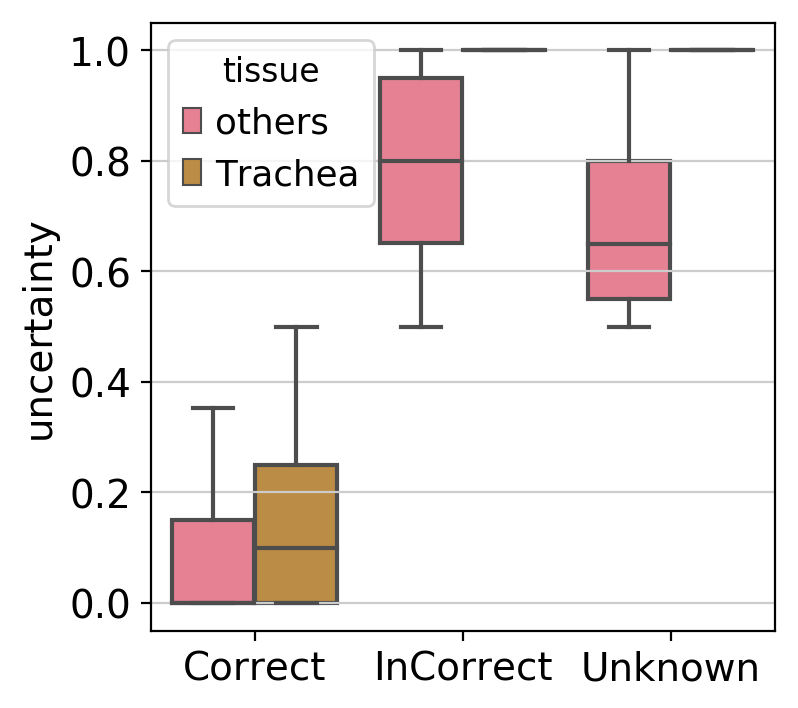

In [40]:
ax = sns.boxplot(x="eval", y='uncertainty', hue="tissue", data=box_plot_df, 
                 showfliers = False, palette=sns.color_palette('husl', 8))
plt.xlabel("")
plt.savefig("./results/classification/tabula_senis_muris/boxplot_celltype.pdf", dpi=200)

# Plot Correct/Incorrect UMAP + Uncertainties UMAP

In [41]:
n_neighbor, threshold = 20, 0.5

In [43]:
sc.set_figure_params(dpi=100)

In [45]:
labels_key = f'celltype_evaluation_w_unknown_{n_neighbor}_{threshold}'
uncertainty_key = f'celltype_uncertainty_w_unknown_{n_neighbor}_{threshold}'

sc.pl.umap(valid_latent, color=labels_key, save=f'_celltype_eval_muris_with_unknown_{n_neighbor}_{threshold}.pdf',
   frameon=False, title='', show=False, palette=sc.pl.palettes.godsnot_102)

sc.pl.umap(valid_latent, color=uncertainty_key, save=f'_celltype_uncertainty_muris_with_unknown_{n_neighbor}_{threshold}.pdf',
           frameon=False, title='', show=False)

sc.pl.umap(valid_latent, color='tissue', save='_tissue_muris.pdf',
           frameon=False, title='', show=False, palette=sc.pl.palettes.godsnot_102)

sc.pl.violin(valid_latent, groupby=labels_key, keys=uncertainty_key, show=False,
             rotation=45, jitter=False, save=f'_celltype_uncertainty_w_unknown_{n_neighbor}_{threshold}.pdf')

In [173]:
sns.set(style='whitegrid')

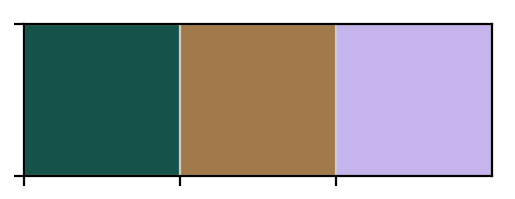

In [39]:
color_palette = sns.color_palette("cubehelix", 3)
sns.palplot(sns.color_palette("cubehelix", 3))

In [11]:
tissues = valid_latent.obs['tissue'].unique().tolist()

In [16]:
results_df = pd.DataFrame(columns=['tissue', 'k', 'prob', 'Correct', 'InCorrect', 'Unknown'])
for tissue in tissues:
    labels_eval_key = f'predicted_tissue_w_unknown_{n_neighbor}_{threshold}'

    tissue_latent = valid_latent[valid_latent.obs['tissue'] == tissue]

    pred_labels = tissue_latent.obs[labels_eval_key].values
    true_labels = tissue_latent.obs['tissue'].values

    labels_eval = np.array(pred_labels) == np.array(true_labels)

    n_correct = len(labels_eval[labels_eval == True])
    n_incorrect = len(labels_eval[labels_eval == False]) - len(labels_eval[pred_labels == 'Unknown'])
    n_unknown = len(labels_eval[pred_labels == 'Unknown'])
    
    new_row = {"tissue": f"{tissue} ({tissue_latent.shape[0]})", "k": n_neighbor, "prob": threshold}

    new_row['Correct'] = n_correct
    new_row['InCorrect'] = n_incorrect
    new_row['Unknown'] = n_unknown

    results_df = results_df.append(new_row, ignore_index=True)

In [25]:
celltype_results_df = pd.DataFrame(columns=['tissue', 'k', 'prob', 'Correct', 'InCorrect', 'Unknown'])
for tissue in tissues:
    labels_eval_key = f'predicted_celltype_w_unknown_20_0.5'

    tissue_latent = valid_latent[valid_latent.obs['tissue'] == tissue]

    pred_labels = tissue_latent.obs[labels_eval_key].values
    true_labels = tissue_latent.obs[cell_type_key].values

    labels_eval = np.array(pred_labels) == np.array(true_labels)

    n_correct = len(labels_eval[labels_eval == True])
    n_incorrect = len(labels_eval[labels_eval == False]) - len(labels_eval[pred_labels == 'Unknown'])
    n_unknown = len(labels_eval[pred_labels == 'Unknown'])
    
    new_row = {"tissue": f"{tissue} ({tissue_latent.shape[0]})", "k": n_neighbor, "prob": threshold}

    new_row['Correct'] = n_correct
    new_row['InCorrect'] = n_incorrect
    new_row['Unknown'] = n_unknown

    celltype_results_df = celltype_results_df.append(new_row, ignore_index=True)

In [29]:
celltype_results_df.loc[celltype_results_df['tissue'].str.startswith('Trachea'), 'Correct'].sum()

799

In [47]:
celltype_results_df.loc[celltype_results_df['tissue'].str.startswith('Trachea'), 'InCorrect'].sum()

6207

In [31]:
celltype_results_df.loc[celltype_results_df['tissue'].str.startswith('Trachea'), 'Unknown'].sum()

2324

In [33]:
celltype_results_df.loc[~celltype_results_df['tissue'].str.startswith('Trachea'), 'Correct'].sum()

67300

In [37]:
celltype_results_df.loc[~celltype_results_df['tissue'].str.startswith('Trachea'), 'InCorrect'].sum()

8093

In [36]:
celltype_results_df.loc[~celltype_results_df['tissue'].str.startswith('Trachea'), 'Unknown'].sum()

5397

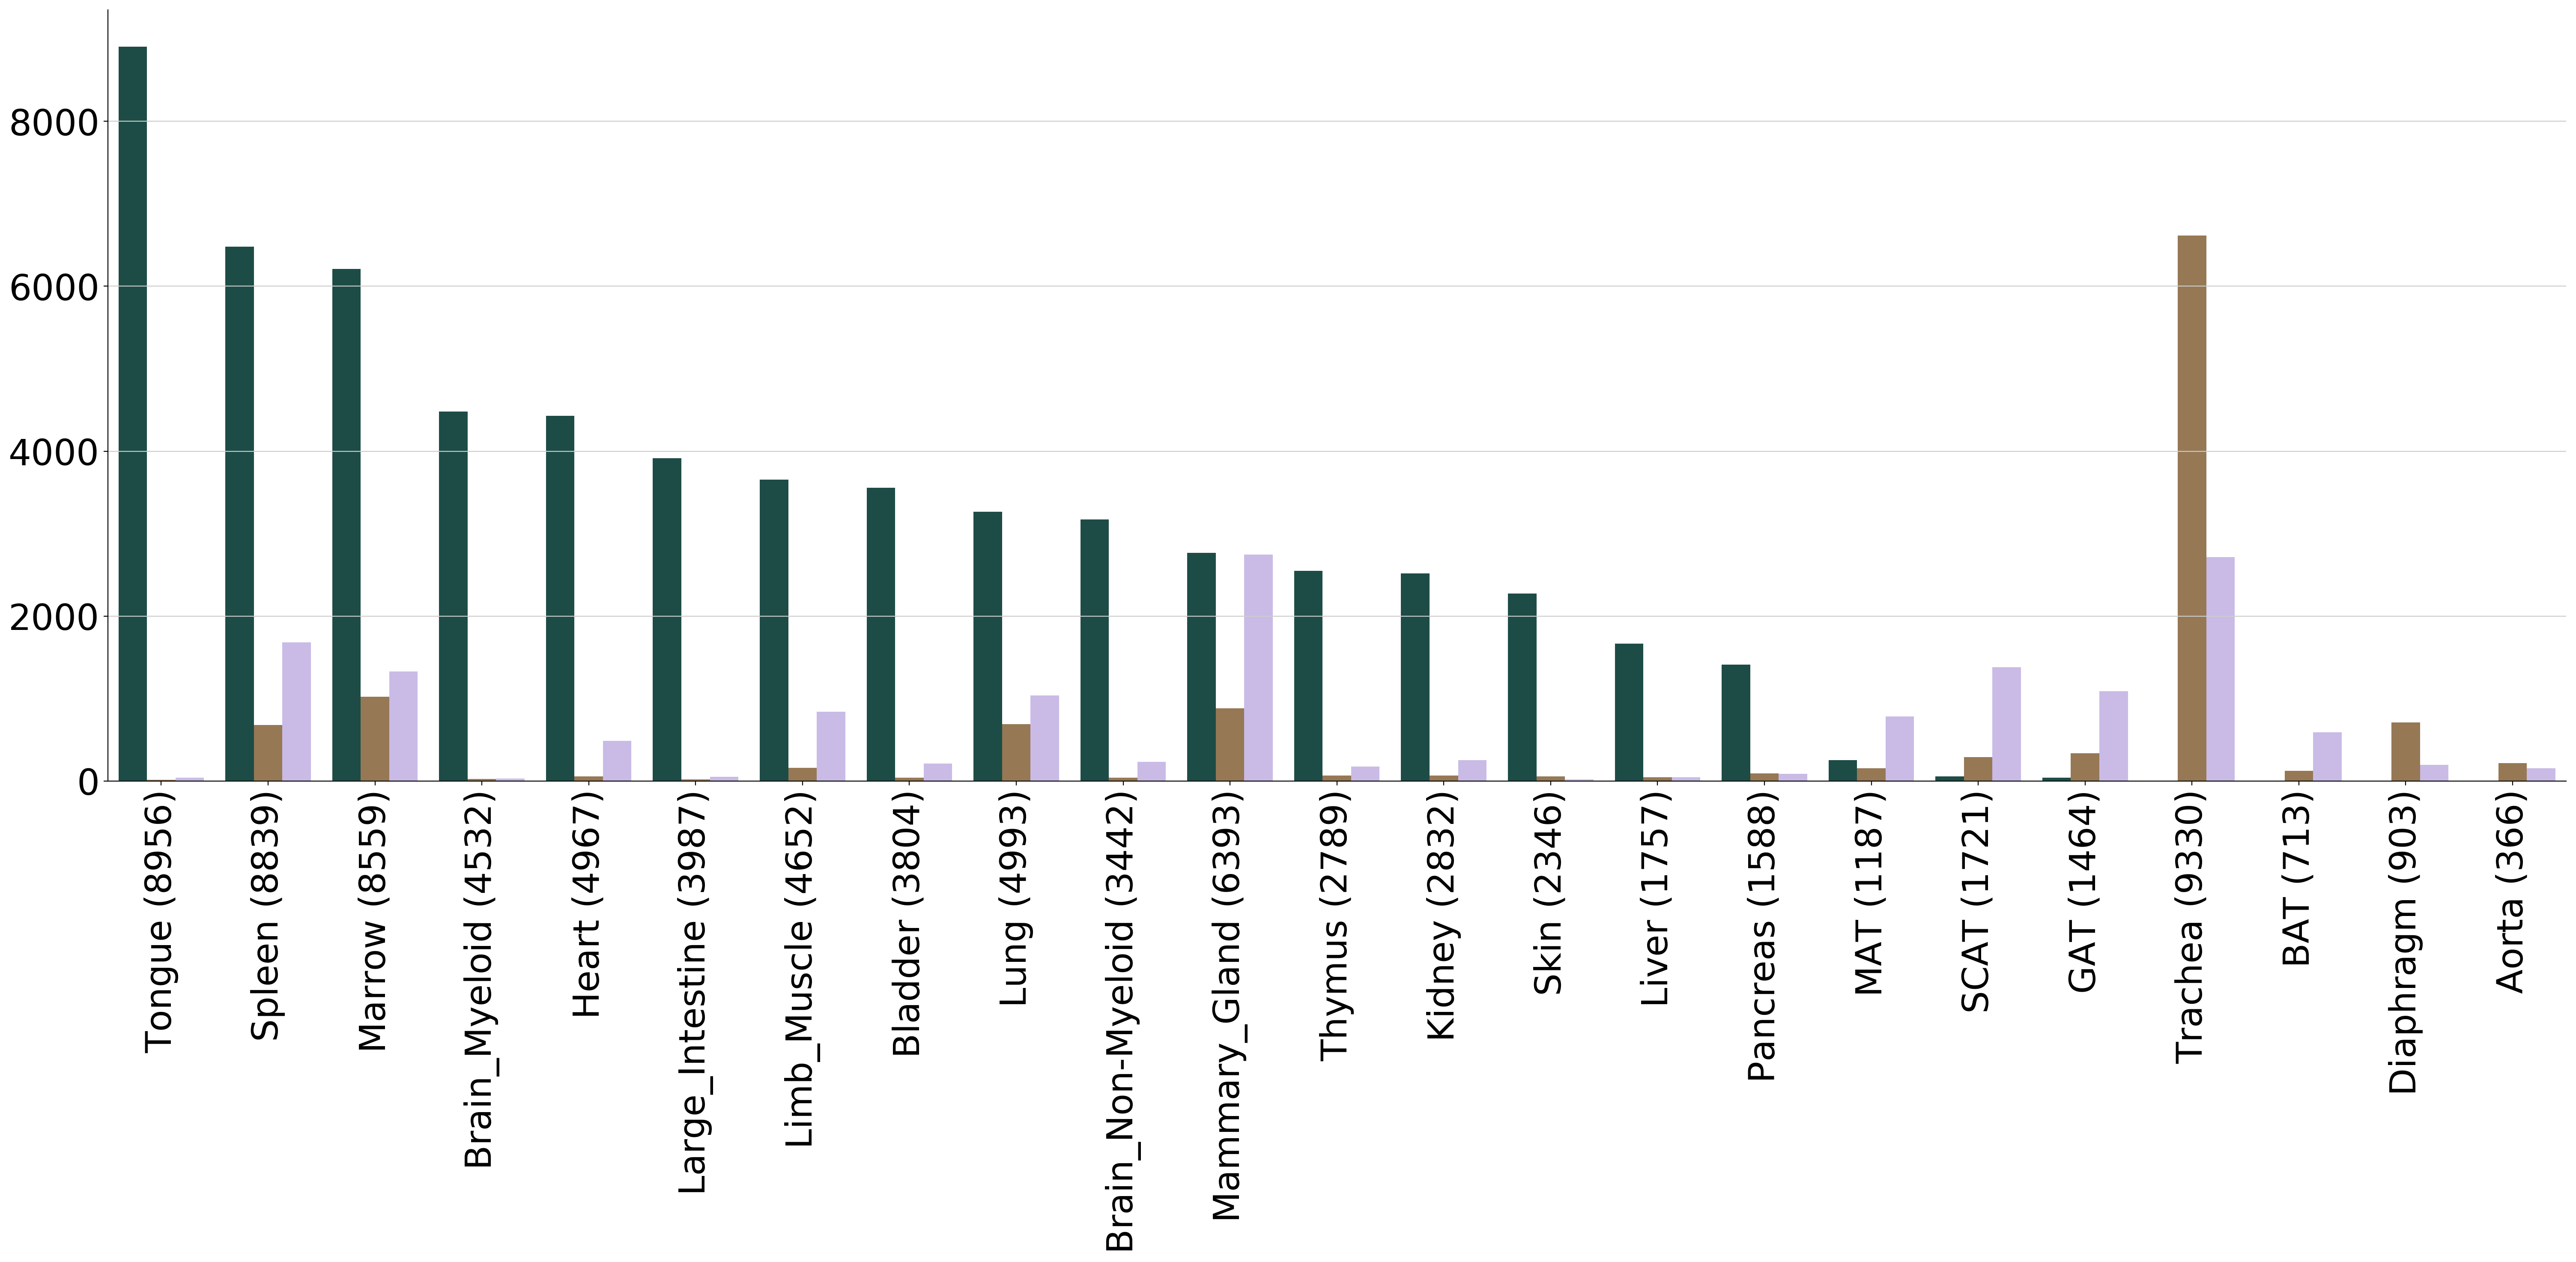

In [40]:
results_df = results_df.sort_values('Correct', ascending=False)
results_df_melted = pd.melt(results_df, id_vars=['k', 'prob', 'tissue'], var_name='type', value_name='n_samples')
barplot = sns.catplot(x='tissue', y='n_samples', hue='type', data=results_df_melted, 
                      kind='bar', height=10, aspect=3, legend=False, palette=color_palette)


plt.xticks(rotation=90, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("")
plt.xlabel("")
plt.savefig(f"./results/classification/tabula_senis_muris/barplot_tissues_classification.pdf", bbox_inches='tight')
# results_df.to_csv("./results/classification/tabula_senis_muris/table_tissues.csv", index=None)
plt.show()
plt.close()

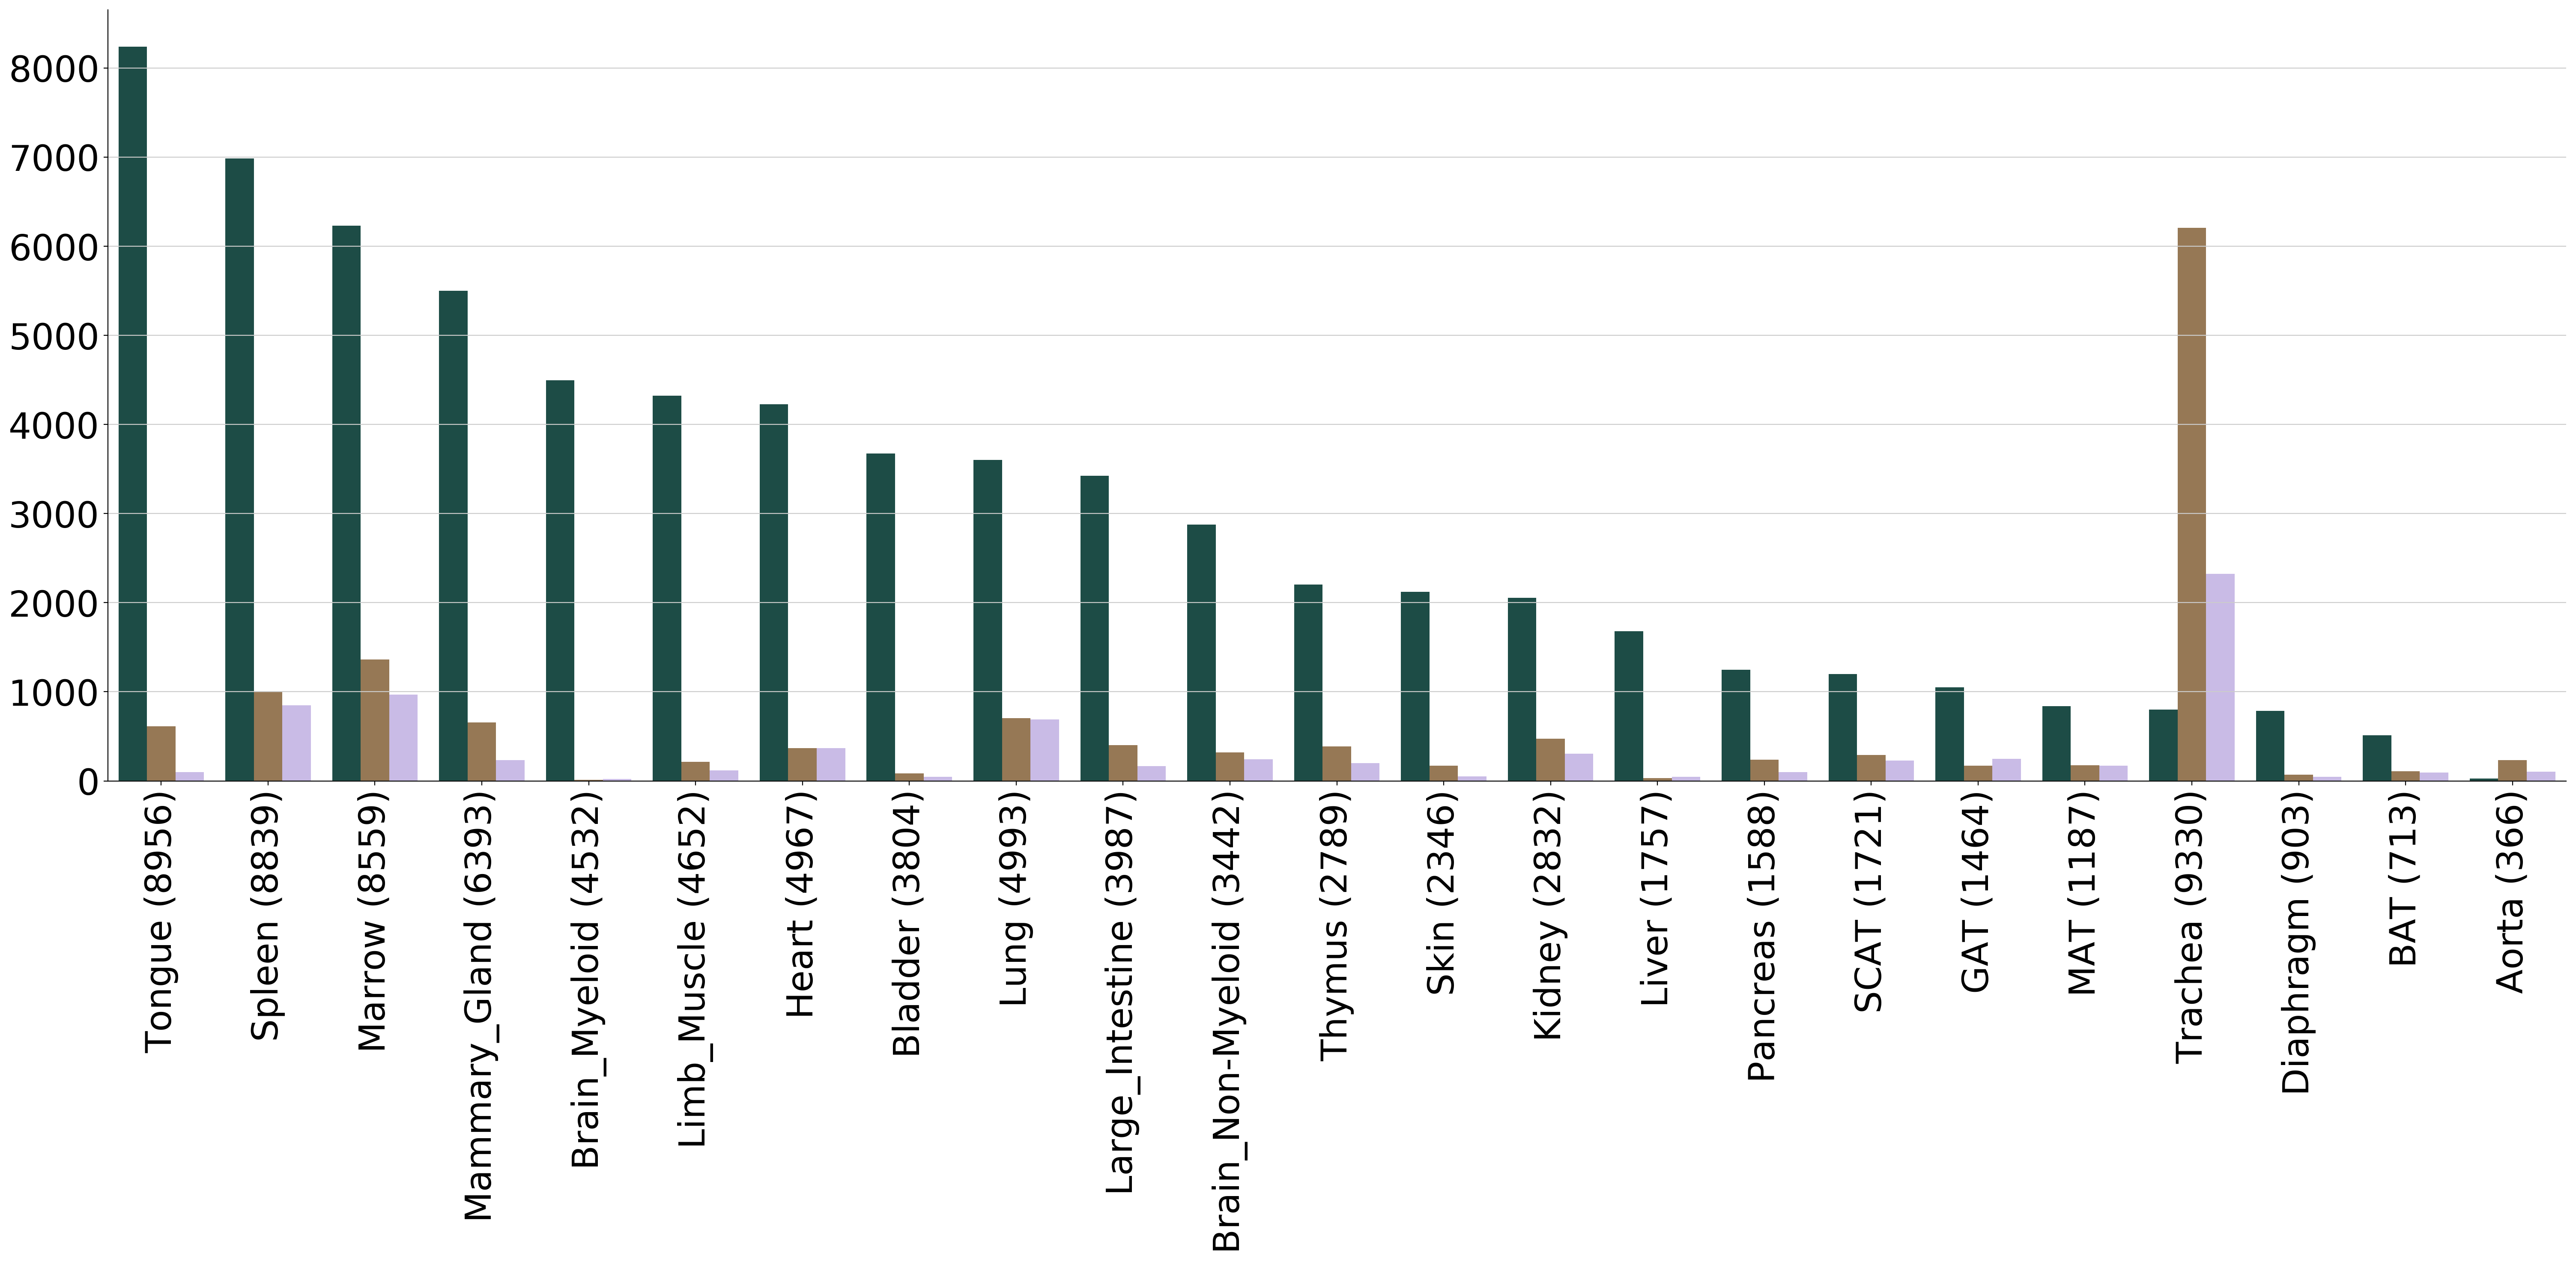

In [46]:
celltype_results_df = celltype_results_df.sort_values('Correct', ascending=False)
results_df_melted = pd.melt(celltype_results_df, id_vars=['k', 'prob', 'tissue'], var_name='type', value_name='n_samples')
barplot = sns.catplot(x='tissue', y='n_samples', hue='type', data=results_df_melted, 
                      kind='bar', height=10, aspect=3, legend=False, palette=color_palette)


plt.xticks(rotation=90, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("")
plt.xlabel("")
plt.savefig(f"./results/classification/tabula_senis_muris/barplot_celltype_classification.pdf", bbox_inches='tight')
# results_df.to_csv("./results/classification/tabula_senis_muris/table_tissues.csv", index=None)
plt.show()
plt.close()

## Generate Sankey plots per tissue

In [13]:
# valid_latent = sc.read("./results/classification/tabula_senis_muris/valid_latent.h5ad")
# valid_latent

AnnData object with n_obs × n_vars = 90120 × 32 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'Tech', 'labels_evaluation_w_unknown_20_0.5', 'uncertainty_w_unknown_20_0.5', 'predicted_labels_w_unknown_20_0.5'

In [97]:
tissues = valid_latent.obs['tissue'].unique().tolist()

In [ ]:
for tissue in tissues:
    print(f'{tissue}...', end='')
    labels_eval_key = f'predicted_labels_w_unknown_{n_neighbor}_{threshold}'
    
    tissue_latent = valid_latent[valid_latent.obs['tissue'] == tissue]
    cell_type_dict = tissue_latent.obs[cell_type_key].value_counts().to_dict()
    labels_eval_dict = tissue_latent.obs[labels_eval_key].value_counts().to_dict()
    
    tissue_latent.obs[cell_type_key] = tissue_latent.obs[cell_type_key].apply(lambda x: f'{x} ({cell_type_dict[x]})')
    tissue_latent.obs[labels_eval_key] = tissue_latent.obs[labels_eval_key].apply(lambda x: f'{x} ({labels_eval_dict[x]})')
    
    pred_labels = tissue_latent.obs[labels_eval_key].values
    true_labels = tissue_latent.obs[cell_type_key].values
    
    pred_labels = np.array(pred_labels).reshape(-1, 1)
    true_labels = np.array(true_labels).reshape(-1, 1)
    
    
        
    plot_data = np.concatenate([true_labels, pred_labels], axis=1)
    
    sn.pl.sankey_diagram(plot_data, v_gap_frac=0.1, h_gap_frac=0.03, figsize=(35, 21), x_range=(5, 20),
                              color_side=1, wdisp_sep=' ', labels=('', ''), disp_width=False,
                              cmap=matplotlib.cm.get_cmap('jet'),
                              save_path=f"./results/classification/tabula_senis_muris/sankey/sankey_{tissue}.pdf",
                              show=False,
                             )
    print("finished!")